<a href="https://colab.research.google.com/github/lucianolcp/projetosbootcamp/blob/main/Sprint_14_Aprendizado_Autom%C3%A1tico_para_Textos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instrução do Projeto

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


A Film Junky Union, uma nova comunidade para entusiastas de filmes clássicos, está desenvolvendo um sistema para filtrar e categorizar resenhas de filmes. O objetivo é treinar um modelo para detectar automaticamente resenhas negativas. Você usará um conjunto de dados de resenhas de filmes do IMDB com rotulagem de polaridade para criar um modelo para classificar resenhas como positivas e negativas. Ele precisará ter um valor F1 de pelo menos 0,85.

## Inicialização

In [2]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# a próxima linha fornece gráficos de melhor qualidade em telas HiDPI
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

<ipython-input-3-bd9eb4c3c37c>:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [4]:
# isso é para usar progress_apply, leia mais em https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Carregar Dados

In [5]:
file_path = '/content/drive/MyDrive/Bootcamp/Sprint14/imdb_reviews.tsv'

# Leitura do arquivo TSV com pandas
df_reviews = pd.read_csv(file_path, sep='\t', dtype={'votes': 'Int64'})

In [ ]:
# Visualizando as primeiras linhas do DataFrame
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [ ]:
# Verificando informações gerais sobre os dados
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [ ]:
# Verificando a distribuição das classes
df_reviews['pos'].value_counts(normalize=True)

0    0.501046
1    0.498954
Name: pos, dtype: float64

## AED

Vamos verificar o número de filmes e resenhas ao longo dos anos.

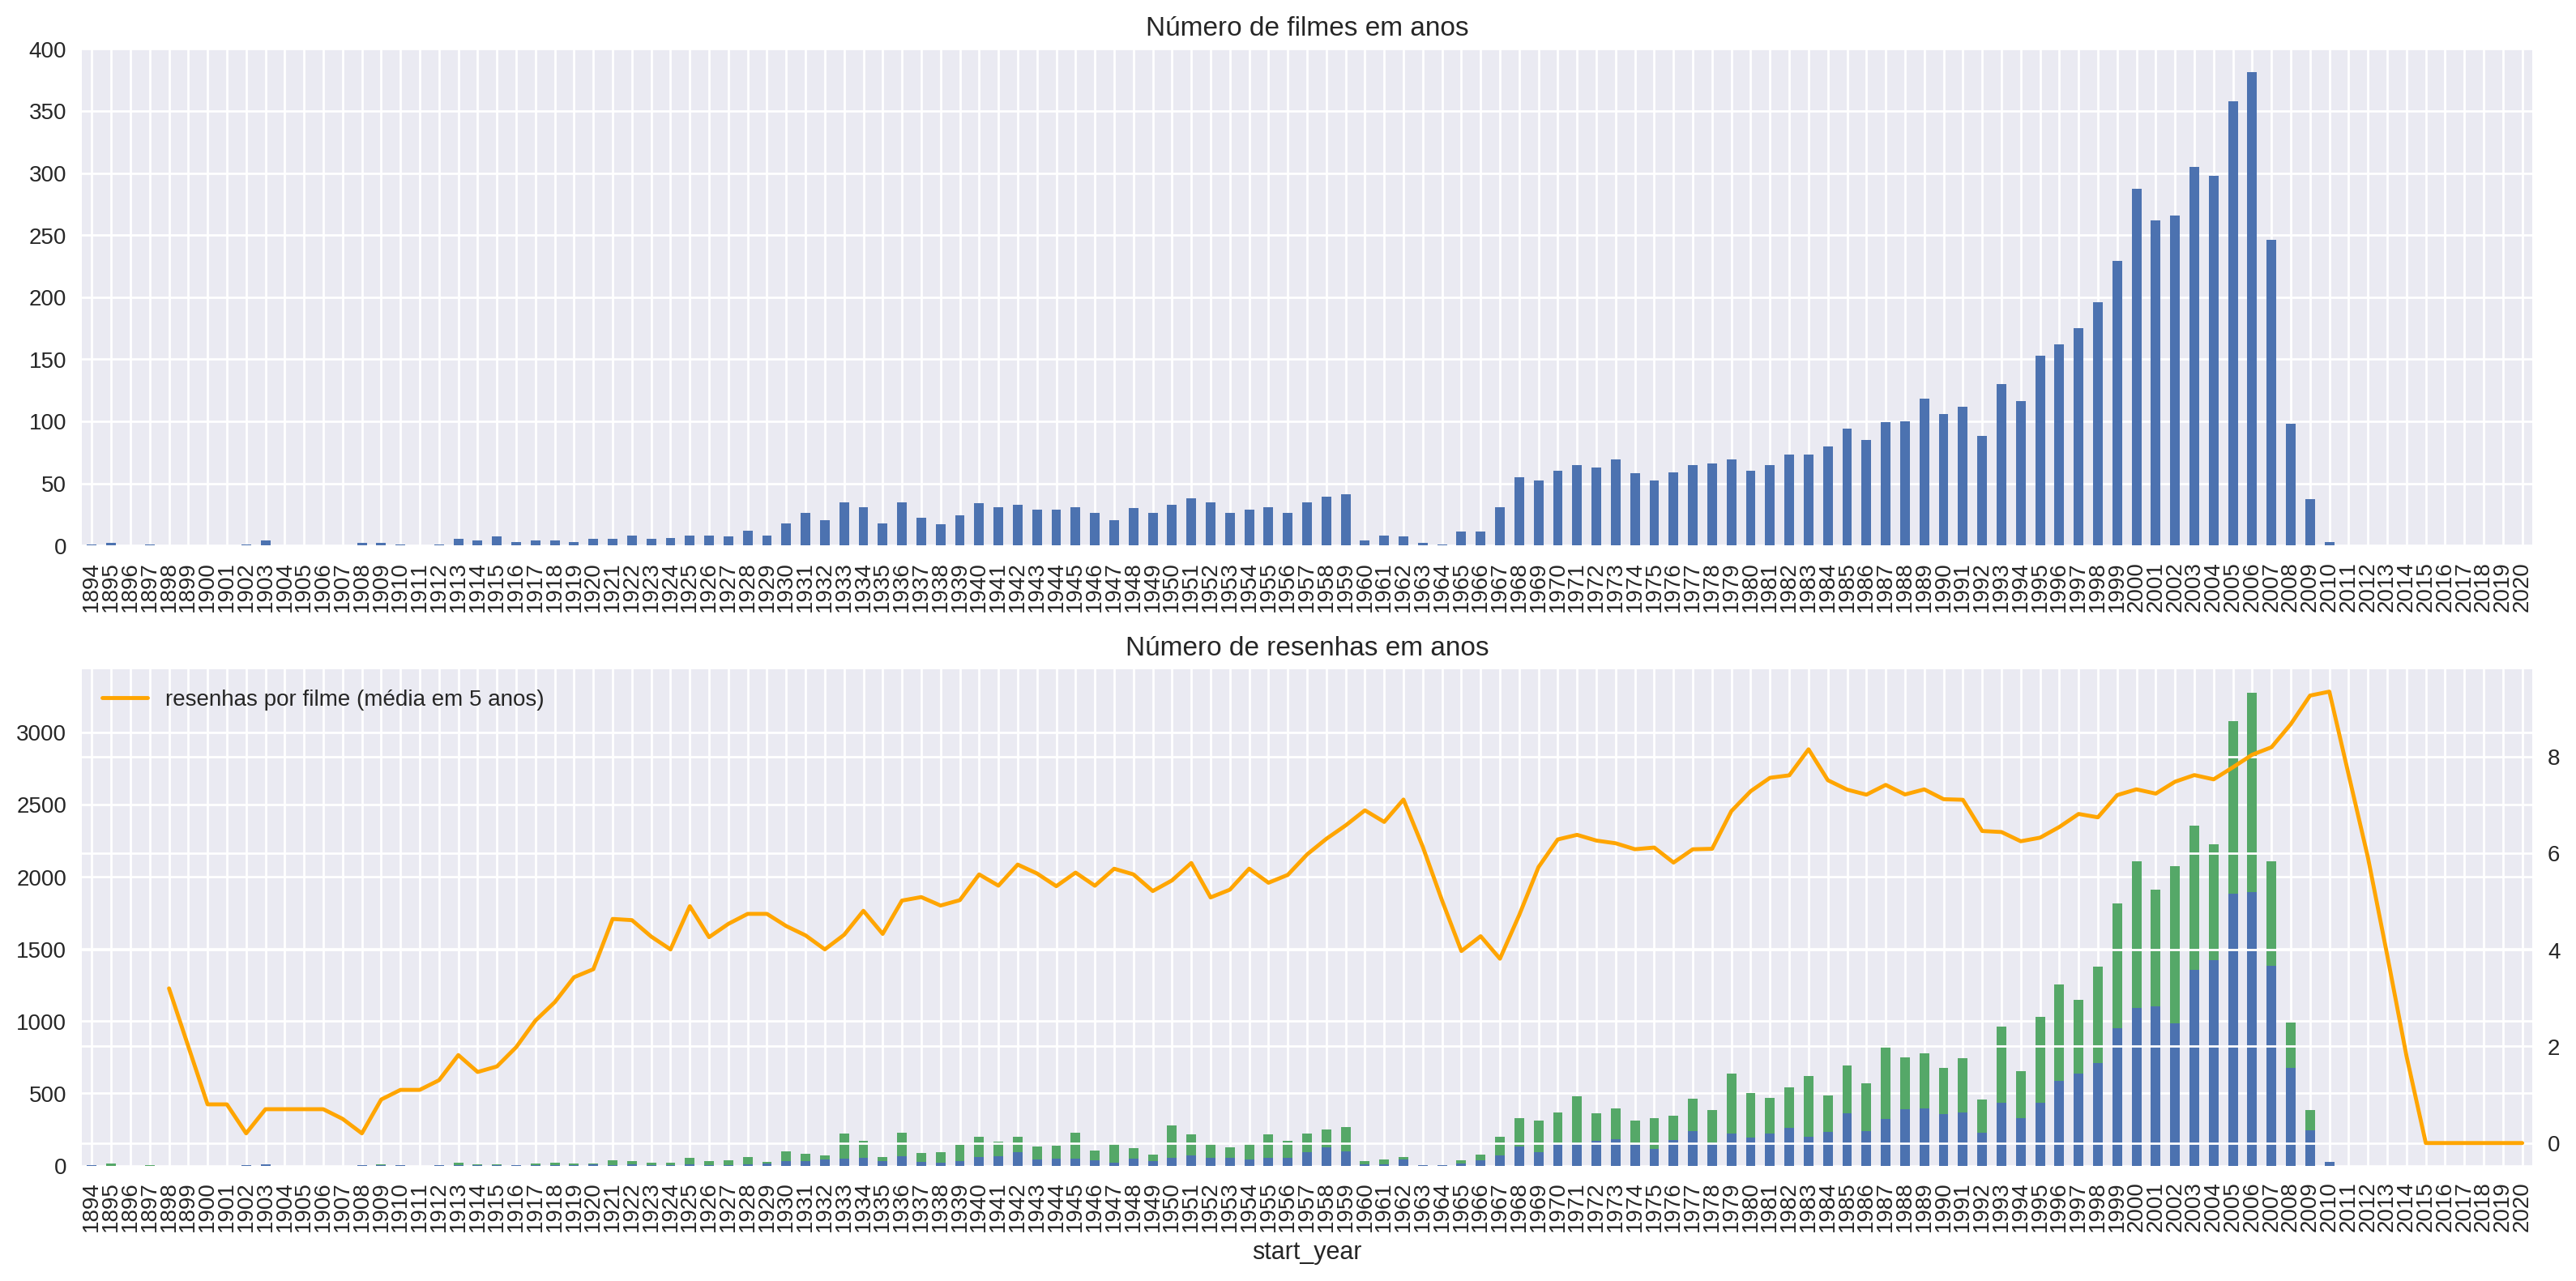

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de filmes em anos')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='resenhas por filme (média em 5 anos)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de resenhas em anos')

fig.tight_layout()

Vamos verificar a distribuição do número de resenhas por filme com a contagem exata e o EDK (Estimativa de densidade kernel - só para saber como pode diferir da contagem exata)

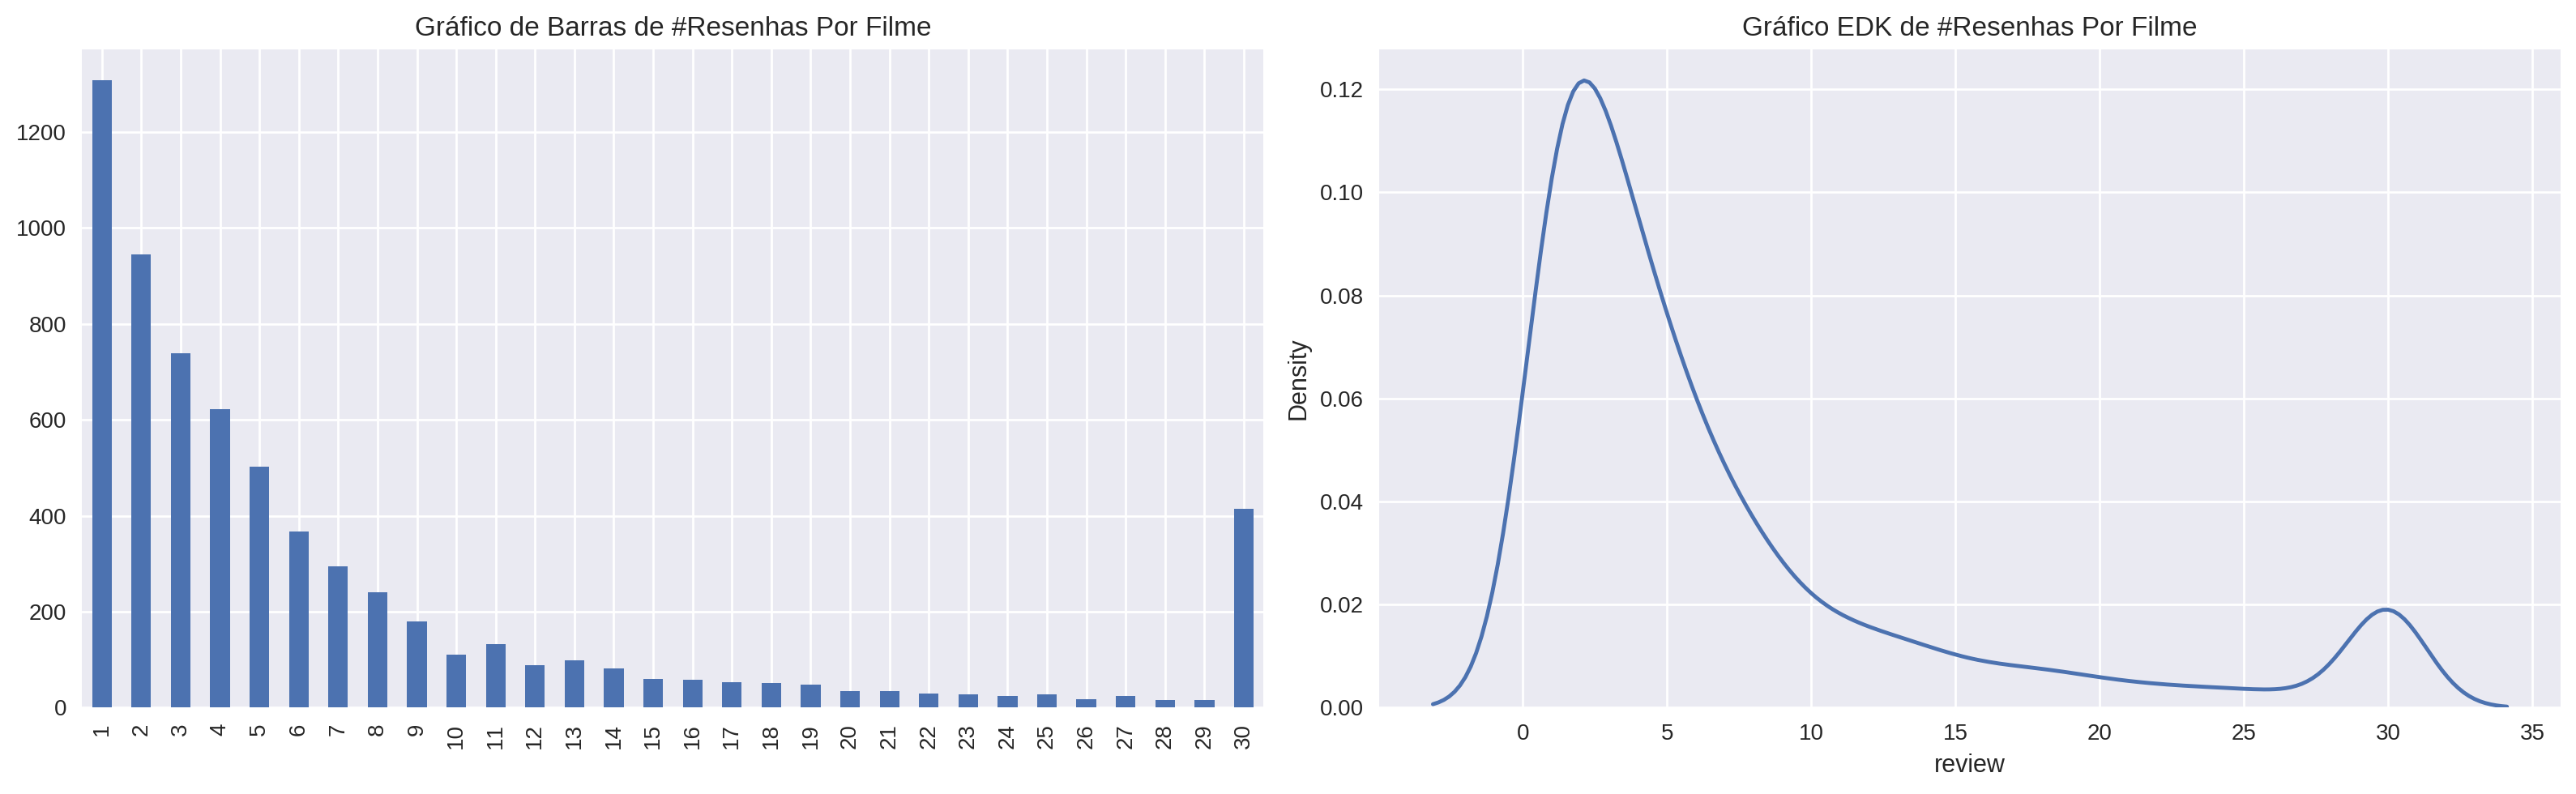

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de Barras de #Resenhas Por Filme')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico EDK de #Resenhas Por Filme')

fig.tight_layout()

In [ ]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

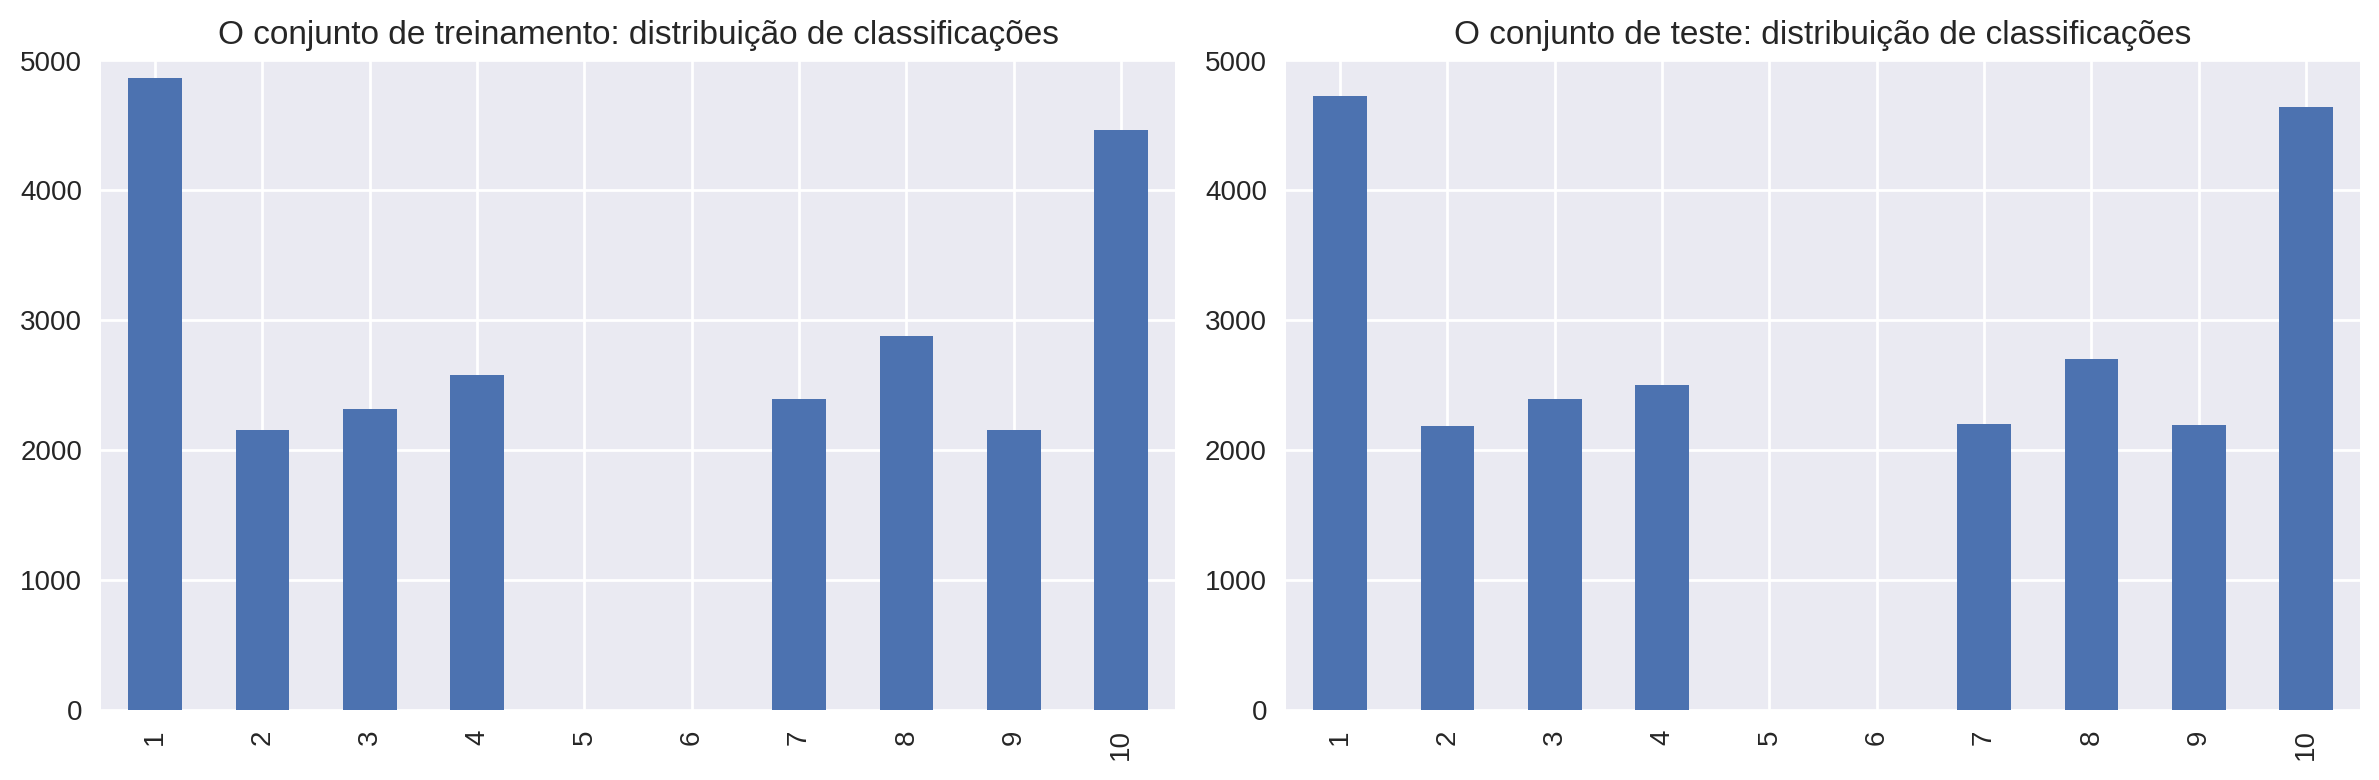

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('O conjunto de treinamento: distribuição de classificações')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('O conjunto de teste: distribuição de classificações')

fig.tight_layout()

Distribuição de resenhas negativas e positivas ao longo dos anos para duas partes do conjunto de dados

/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


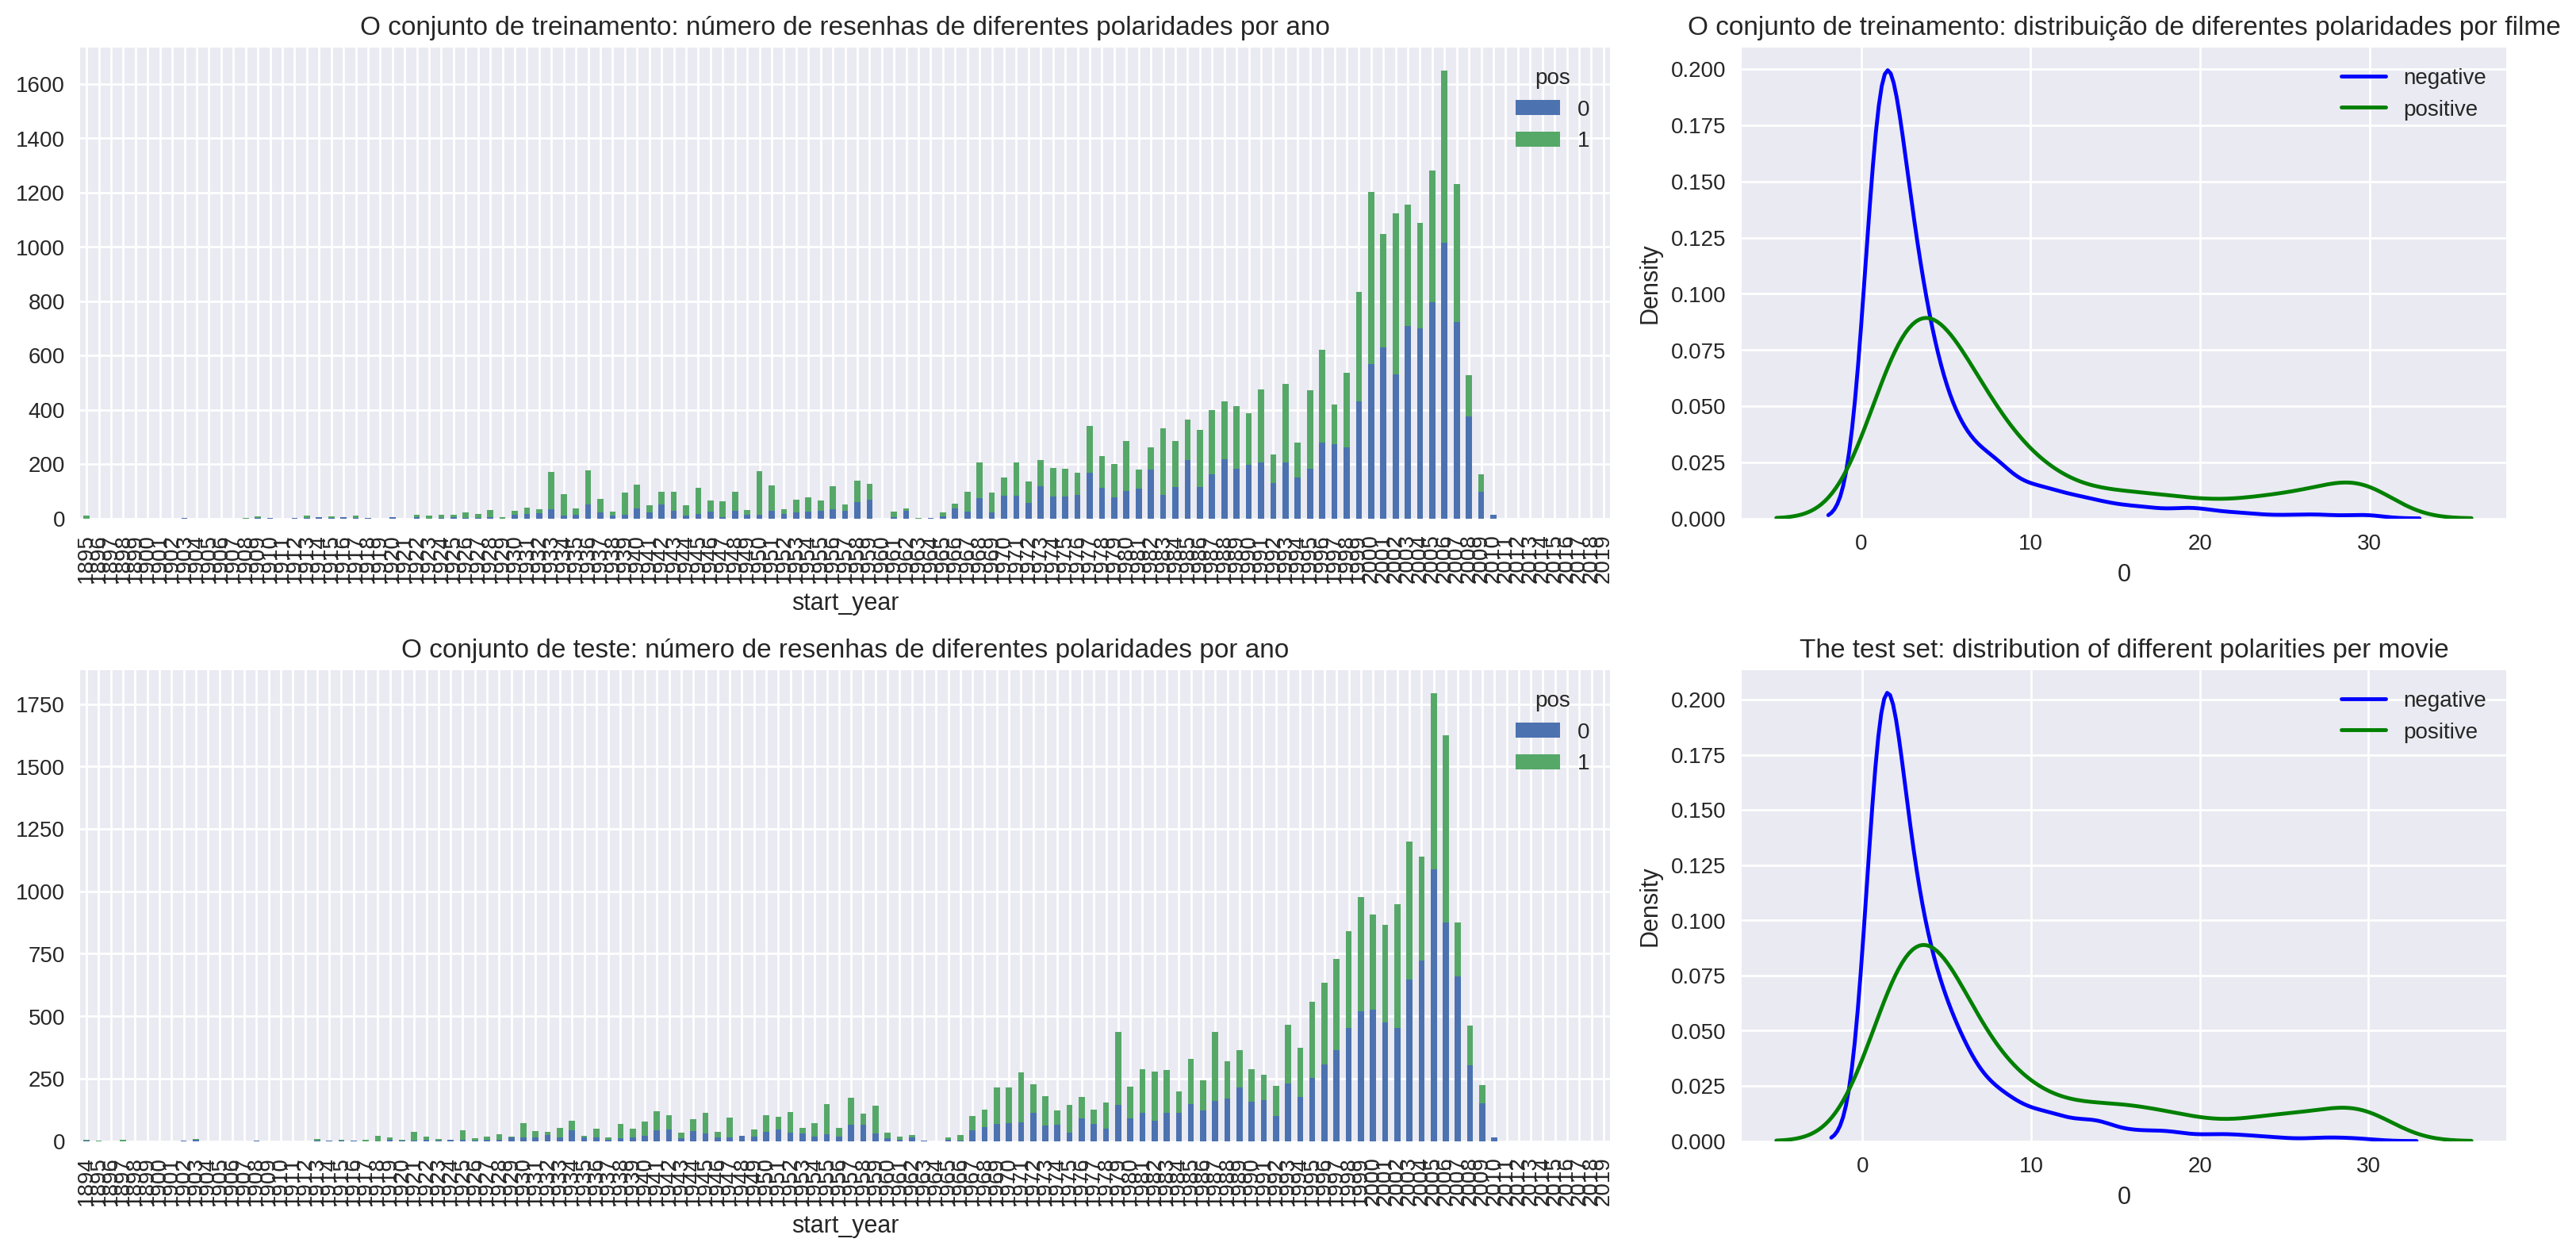

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('O conjunto de treinamento: número de resenhas de diferentes polaridades por ano')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('O conjunto de treinamento: distribuição de diferentes polaridades por filme')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('O conjunto de teste: número de resenhas de diferentes polaridades por ano')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

## Procedimento de Avaliação

Compondo uma rotina de avaliação que pode ser utilizada para todos os modelos deste projeto

In [ ]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):

    eval_stats = {}

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):

        eval_stats[type] = {}

        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]

        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]

        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[type]['ROC AUC'] = roc_auc

        # Curva de precisão-revocação
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps

        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # definindo cruzamentos para alguns limiares
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1')

        # ROC
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')
        ax.set_title(f'Curva ROC')

        # Curva de precisão-revocação
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # definindo cruzamentos para alguns limiares
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)

    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Acurácia', 'F1', 'APS', 'ROC AUC'))

    print(df_eval_stats)

    return

## Normalização

Assumimos que todos os modelos abaixo aceitam textos em letras minúsculas e sem dígitos, sinais de pontuação, etc.

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Certifique-se de baixar os pacotes necessários do NLTK, se ainda não tiver feito:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Inicializando o lematizador e as stop words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Função de normalização
def normalize_review(text):
    # Convertendo para minúsculas
    text = text.lower()
    # Removendo pontuação e caracteres especiais
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenizando
    tokens = text.split()
    # Removendo stop words e aplicando lematização
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    # Juntando de volta em uma string
    return ' '.join(tokens)

# Aplicando a normalização
df_reviews['review_norm'] = df_reviews['review'].apply(normalize_review)

# Visualizando o resultado
df_reviews[['review', 'review_norm']].head()


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...
[nltk_data] Error downloading 'omw-1.4' from
[nltk_data]     <https://raw.githubusercontent.com/nltk/nltk_data/gh-
[nltk_data]     pages/packages/corpora/omw-1.4.zip>:   [Errno 13]
[nltk_data]     Permission denied:
[nltk_data]     '/home/jovyan/nltk_data/corpora/omw-1.4.zip'


,review,review_norm
0,The pakage implies that Warren Beatty and Gold...,pakage implies warren beatty goldie hawn pulli...
1,How the hell did they get this made?! Presenti...,hell get made presenting caper comedy misbegot...
2,There is no real story the film seems more lik...,real story film seems like fly wall dramadocum...
3,Um .... a serious film about troubled teens in...,um serious film troubled teen singapore countr...
4,I'm totally agree with GarryJohal from Singapo...,im totally agree garryjohal singapore comment ...


## Treinar / Testar Conjunto

Felizmente, todo o conjunto de dados já está dividido em partes de treinamento/teste. A opção correspondente é 'ds_part'.

In [ ]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Trabalhando com modelos

### Modelo 0 - Constante

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report


In [ ]:
# Criando o pipeline com um DummyClassifier
pipeline_dummy = Pipeline([
    ('vectorizer', CountVectorizer()),  # Vetorização do texto
    ('scaler', StandardScaler(with_mean=False)),  # Escalagem (não aplicável a dados esparsos, por isso with_mean=False)
    ('classifier', DummyClassifier(strategy='most_frequent'))  # Classificador constante
])

# Treinando o modelo
pipeline_dummy.fit(df_reviews_train['review_norm'], train_target)

# Fazendo previsões no conjunto de teste
predictions_test_dummy = pipeline_dummy.predict(df_reviews_test['review_norm'])

# Avaliando o modelo
print("Modelo Dummy (Constante) - Avaliação no Conjunto de Teste:")
print(classification_report(test_target, predictions_test_dummy))


Modelo Dummy (Constante) - Avaliação no Conjunto de Teste:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67     11803
           1       0.00      0.00      0.00     11732

    accuracy                           0.50     23535
   macro avg       0.25      0.50      0.33     23535
weighted avg       0.25      0.50      0.34     23535



/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


- Precisão (Precision) para a classe positiva (1) é 0.00, pois o modelo não está prevendo nenhuma amostra como positiva.

- Recall para a classe negativa (0) é 1.00, indicando que todas as amostras negativas foram corretamente classificadas.

- F1-Score é baixo para a classe positiva, refletindo que o modelo não está identificando amostras positivas.

Como esperado, o DummyClassifier classifica todas as amostras como pertencentes à classe mais frequente. Isso fornece uma linha de base para comparar com outros modelos que devem mostrar um desempenho melhor ao identificar corretamente ambas as classes.

### Modelo 1 - NLTK, TF-IDF e Regressão Linear

In [ ]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [ ]:
from sklearn.pipeline import Pipeline


In [ ]:
# Baixar as stopwords do NLTK (se necessário)
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


          train  test
Acurácia    NaN   NaN
F1          NaN   NaN
APS        0.98  0.95
ROC AUC    0.98  0.95


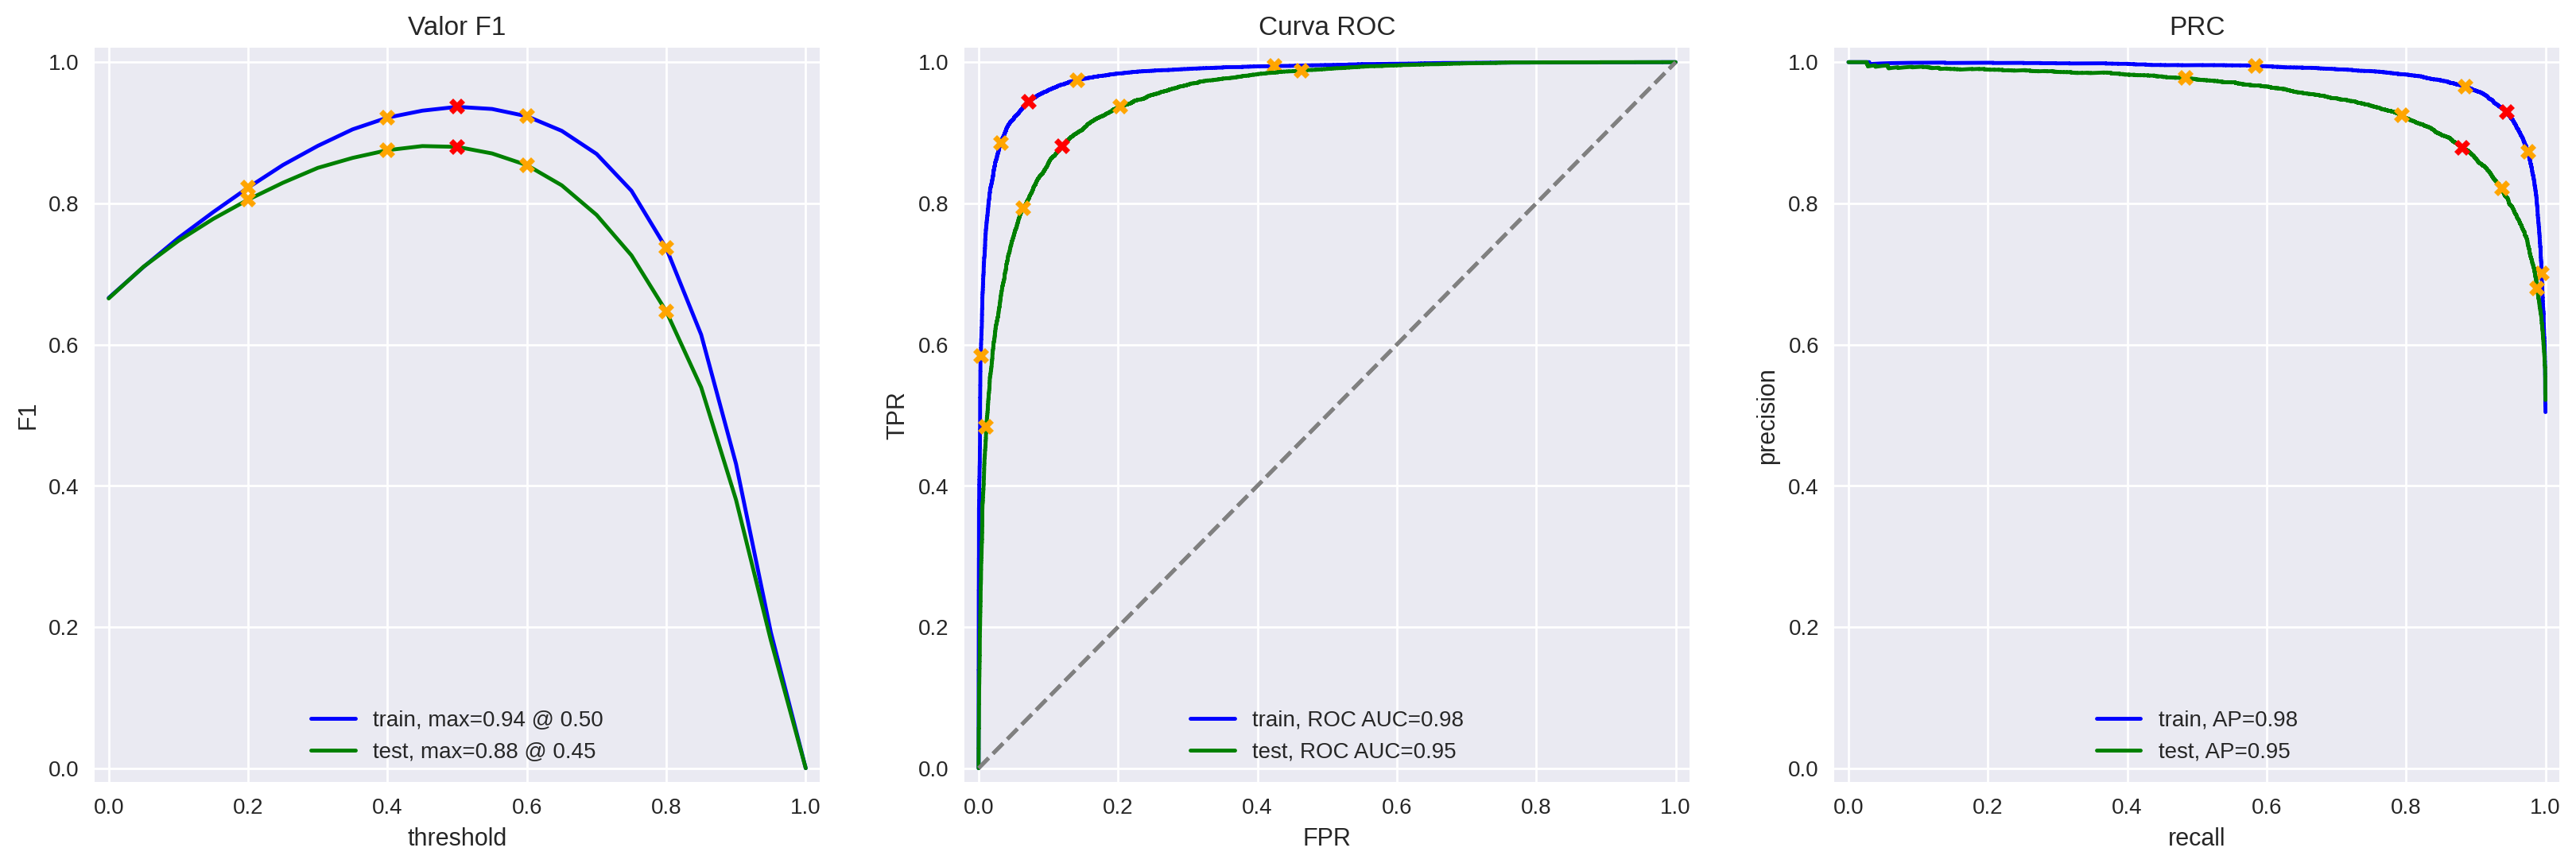

In [ ]:
# Separando características e alvo para treino e teste
train_features_1 = df_reviews_train['review_norm']
test_features_1 = df_reviews_test['review_norm']

# Manter as variáveis alvo como definidas anteriormente
train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

# Criando o pipeline com vetorização TF-IDF e Regressão Logística
pipeline_logistic_nltk = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words=stop_words)),  # Vetorização TF-IDF com stopwords do NLTK
    ('classifier', LogisticRegression(max_iter=1000, random_state=123))  # Regressão Logística
])

# Treinando o modelo com os dados de treino
pipeline_logistic_nltk.fit(train_features_1, train_target)

# Avaliação do modelo utilizando uma função de avaliação
evaluate_model(pipeline_logistic_nltk, train_features_1, train_target, test_features_1, test_target)


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, average_precision_score, roc_auc_score

# Função para avaliar o modelo
def evaluate_model(model, train_features, train_target, test_features, test_target):
    # Previsões nos conjuntos de treino e teste
    train_preds = model.predict(train_features)
    test_preds = model.predict(test_features)

    # Probabilidades para APS e ROC AUC
    train_probs = model.predict_proba(train_features)[:, 1]
    test_probs = model.predict_proba(test_features)[:, 1]

    # Calculando as métricas
    metrics = {
        'Acurácia': [
            accuracy_score(train_target, train_preds),
            accuracy_score(test_target, test_preds)
        ],
        'F1': [
            f1_score(train_target, train_preds),
            f1_score(test_target, test_preds)
        ],
        'APS': [
            average_precision_score(train_target, train_probs),
            average_precision_score(test_target, test_probs)
        ],
        'ROC AUC': [
            roc_auc_score(train_target, train_probs),
            roc_auc_score(test_target, test_probs)
        ]
    }

    # Exibindo os resultados
    results_df = pd.DataFrame(metrics, index=['Train', 'Test']).transpose()
    print(results_df)

# Avaliação do modelo ajustado
evaluate_model(pipeline_logistic_nltk, train_features_1, train_target, test_features_1, test_target)

             Train      Test
Acurácia  0.936292  0.880263
F1        0.936738  0.880024
APS       0.982835  0.947895
ROC AUC   0.982296  0.950280


**Análise dos Resultados:**

- Acurácia:
A acurácia no conjunto de treino é alta (93.6%), e no teste também é boa (88.0%), indicando que o modelo está generalizando relativamente bem para dados não vistos.

- F1-Score:
O F1-Score é semelhante à acurácia, o que sugere que o modelo está equilibrando bem precisão e recall, importante para problemas de classificação.

- APS:
O Average Precision Score está bem elevado, mostrando que o modelo está classificando corretamente com alta confiança.

- ROC AUC:
A pontuação ROC AUC acima de 0.95 no teste é um excelente indicador de desempenho, mostrando que o modelo é muito eficaz em distinguir entre as classes positivas e negativas.

### Modelo 2 - spaCy, TF-IDF e Regressão Linear

In [ ]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [ ]:
def text_preprocessing_3(text):

    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]

    return ' '.join(tokens)

In [ ]:
# Aplicar a função de pré-processamento aos conjuntos de treino e teste
df_reviews_train['review_norm_3'] = df_reviews_train['review_norm'].apply(text_preprocessing_3)
df_reviews_test['review_norm_3'] = df_reviews_test['review_norm'].apply(text_preprocessing_3)

# Criar o pipeline para vetorização TF-IDF e Regressão Logística
pipeline_logistic_spacy = Pipeline([
    ('vectorizer', TfidfVectorizer()),  # Vetorização TF-IDF sem stopwords
    ('classifier', LogisticRegression(max_iter=1000, random_state=123))  # Regressão Logística
])

# Treinar o modelo com os dados de treino
pipeline_logistic_spacy.fit(df_reviews_train['review_norm_3'], train_target)

# Fazer previsões no conjunto de teste
predictions = pipeline_logistic_spacy.predict(df_reviews_test['review_norm_3'])
probabilities = pipeline_logistic_spacy.predict_proba(df_reviews_test['review_norm_3'])[:, 1]

In [ ]:
# Avaliação do modelo
print("Modelo 3 - spaCy, TF-IDF e Regressão Linear:")
print("Classification Report:")
print(classification_report(test_target, predictions))
print(f"ROC AUC Score: {roc_auc_score(test_target, probabilities):.4f}")
print(f"Average Precision Score: {average_precision_score(test_target, probabilities):.4f}")


Modelo 3 - spaCy, TF-IDF e Regressão Linear:
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.87      0.88     11803
           1       0.87      0.88      0.88     11732

    accuracy                           0.88     23535
   macro avg       0.88      0.88      0.88     23535
weighted avg       0.88      0.88      0.88     23535

ROC AUC Score: 0.9482
Average Precision Score: 0.9458


- Acurácia: 0.88, o que indica que o modelo classificou corretamente 88% dos exemplos.
- F1-Score: Ambos os rótulos (0 e 1) apresentam um F1-Score de 0.88, refletindo um equilíbrio sólido entre precisão e recall.
- ROC AUC Score: 0.9482, sugerindo que o modelo distingue bem entre as classes.
- Average Precision Score: 0.9458, indicando que o modelo está bom em prever a classe positiva.

*Comparação com Modelos Anteriores:*

Este modelo se aproxima dos melhores resultados vistos até agora (modelo com NLTK), sugerindo que as técnicas de processamento com spaCy são comparáveis e igualmente eficientes.

### Modelo 3 - SpaCy, TF-IDF e LGBMClassifier

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.preprocessing import FunctionTransformer

In [ ]:
# Carregar o modelo de SpaCy sem 'parser' e 'ner' para acelerar o processamento
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Função de pré-processamento
def text_preprocessing_3(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc]  # Lematização
    return ' '.join(tokens)

# Criar o pipeline
pipeline_spacy_tfidf_lgbm = Pipeline([
    ('preprocessor', FunctionTransformer(func=lambda x: x.apply(text_preprocessing_3), validate=False)),  # Aplicar pré-processamento com SpaCy
    ('vectorizer', TfidfVectorizer(max_features=5000, stop_words='english')),  # Vetorização TF-IDF
    ('classifier', LGBMClassifier(random_state=123, n_estimators=100, max_depth=10, learning_rate=0.1))  # Modelo LGBMClassifier
])

# Treinar o pipeline
pipeline_spacy_tfidf_lgbm.fit(df_reviews_train['review'], train_target)

# Fazer previsões e avaliações no conjunto de teste
train_predictions_3 = pipeline_spacy_tfidf_lgbm.predict(df_reviews_train['review'])
test_predictions_3 = pipeline_spacy_tfidf_lgbm.predict(df_reviews_test['review'])
test_probabilities_3 = pipeline_spacy_tfidf_lgbm.predict_proba(df_reviews_test['review'])[:, 1]

# Avaliação do modelo
print("Train Classification Report:")
print(classification_report(train_target, train_predictions_3))

print("\nTest Classification Report:")
print(classification_report(test_target, test_predictions_3))

print(f"ROC AUC Score: {roc_auc_score(test_target, test_probabilities_3):.4f}")
print(f"Average Precision Score: {average_precision_score(test_target, test_probabilities_3):.4f}")


Train Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.87      0.89     11912
           1       0.88      0.92      0.90     11884

    accuracy                           0.90     23796
   macro avg       0.90      0.90      0.90     23796
weighted avg       0.90      0.90      0.90     23796


Test Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.81      0.83     11803
           1       0.82      0.86      0.84     11732

    accuracy                           0.84     23535
   macro avg       0.84      0.84      0.84     23535
weighted avg       0.84      0.84      0.84     23535

ROC AUC Score: 0.9210
Average Precision Score: 0.9179


**Análise:**
    
Bom balanceamento entre Precisão e Recall: O modelo mantém um bom equilíbrio, crucial para aplicações que demandam alta sensibilidade (recall) e precisão.

Ligeira queda no desempenho de Treino para Teste: A diferença entre as métricas de treino e teste sugere que o modelo é capaz de generalizar bem para novos dados, com uma leve queda de desempenho no conjunto de teste, o que é esperado e indica bom ajuste.

ROC AUC e APS altos: Ambos os scores refletem uma boa capacidade de classificação e previsão do modelo.

## Minhas Resenhas

<div class="alert alert-block alert-danger">
<b> Comentário do revisor: </b> <a class="tocSkip"></a>

Usar resenhas em inglês
</div>

In [ ]:
my_reviews = pd.DataFrame([
    'Eu simplesmente não gostei, não é meu tipo de filme.',
    'Bem, eu fiquei entediado e dormi no meio do filme.',
    'Eu fiquei realmente fascinado com o filme',
    'Os atores pareciam muito velhos e desinteressados, e mesmo assim foram pagos para participar do filme. Que roubo de dinheiro sem vergonha.',
    'Eu não esperava que a nova versão fosse tão boa! Os escritores realmente se importaram com o material original',
    'O filme tem seus prós e contras, mas eu sinto que em geral é um filme decente. Eu posso me imaginar indo assistir novamente.',
    'Que tentativa podre de comédia. Nem uma única piada cai, todo mundo age de forma irritante e barulhenta, nem crianças não vão gostar disso!',
    'Lançar na Netflix foi uma jogada corajosa e eu realmente aprecio ser capaz de assistir episódio após episódio, deste emocionante e inteligente novo drama.',
    'Infelizmente, o enredo é previsível e nada original, já vi filmes parecidos dezenas de vezes.',
    'Os diálogos foram extremamente forçados e parecia que os atores estavam lendo um teleprompter.',
    'Eu fui surpreendido pelo roteiro inovador e pelos personagens cativantes, realmente uma obra prima inesperada.',
    'Um completo desperdício de tempo, sem emoção, sem química entre os personagens, simplesmente ruim.',
    'Péssima escolha de elenco, os protagonistas não convencem e a atuação é muito amadora.',
    'A trilha sonora é incrível e encaixa perfeitamente com as cenas, me deixou imerso do começo ao fim.',
    'Achei a cinematografia belíssima, cheia de detalhes sutis que adicionam profundidade à história',
    'Gostei de como o filme aborda temas complexos de forma acessível e interessante, vale a pena assistir.',
    'O filme tenta ser profundo, mas acaba se perdendo em clichês e situações sem sentido.',
    'Uma tentativa fracassada de criar algo épico, mas que só resulta em um filme longo e cansativo.'

], columns=['review'])

In [ ]:
import pandas as pd

my_reviews = pd.DataFrame([
    'I just didn’t like it, it’s not my kind of movie.',
    'Well, I got bored and fell asleep in the middle of the film.',
    'I was really captivated by the movie.',
    'The actors seemed very old and disinterested, and they were still paid to be in the film. What a shameless money grab.',
    'I didn’t expect the new version to be so good! The writers really cared about the original material.',
    'The film has its pros and cons, but overall I feel it’s a decent movie. I can see myself watching it again.',
    'What a pathetic attempt at comedy. Not a single joke lands, everyone acts in an annoying and loud manner—kids won’t even like this!',
    'Releasing it on Netflix was a bold move, and I really appreciate being able to binge-watch episode after episode of this thrilling and smart new drama.',
    'Unfortunately, the plot is predictable and unoriginal; I’ve seen similar movies dozens of times.',
    'The dialogues were extremely forced, and it felt like the actors were reading from a teleprompter.',
    'I was surprised by the innovative script and the engaging characters—truly an unexpected masterpiece.',
    'A complete waste of time, with no excitement, no chemistry between the characters—just bad.',
    'Terrible casting choice, the leads are unconvincing, and the acting is very amateurish.',
    'The soundtrack is amazing and fits perfectly with the scenes, keeping me engaged from start to finish.',
    'I found the cinematography beautiful, with subtle details that add depth to the story.',
    'I liked how the film tackles complex themes in an accessible and interesting way—it’s worth watching.',
    'The film tries to be profound but ends up lost in clichés and nonsensical situations.',
    'A failed attempt to create something epic, resulting in just a long and tiresome movie.'
], columns=['review'])


In [ ]:
# Função de normalização que utilizamos anteriormente
def normalize_text(text):
    text = text.lower()  # Converter para minúsculas
    text = re.sub(r'[^\w\s]', '', text)  # Remover pontuação
    text = re.sub(r'\d+', '', text)  # Remover números
    return text

# Aplicar normalização nas resenhas
my_reviews['review_norm'] = my_reviews['review'].apply(normalize_text)

# Visualizar as resenhas normalizadas
my_reviews

,review,review_norm
0,"I just didn’t like it, it’s not my kind of movie.",i just didnt like it its not my kind of movie
1,"Well, I got bored and fell asleep in the middl...",well i got bored and fell asleep in the middle...
2,I was really captivated by the movie.,i was really captivated by the movie
3,"The actors seemed very old and disinterested, ...",the actors seemed very old and disinterested a...
4,I didn’t expect the new version to be so good!...,i didnt expect the new version to be so good t...
5,"The film has its pros and cons, but overall I ...",the film has its pros and cons but overall i f...
6,What a pathetic attempt at comedy. Not a singl...,what a pathetic attempt at comedy not a single...
7,"Releasing it on Netflix was a bold move, and I...",releasing it on netflix was a bold move and i ...
8,"Unfortunately, the plot is predictable and uno...",unfortunately the plot is predictable and unor...
9,"The dialogues were extremely forced, and it fe...",the dialogues were extremely forced and it fel...


In [ ]:
# Função para prever e imprimir resultados
def classify_reviews(reviews, model, model_name):
    predictions = model.predict(reviews['review_norm'])
    print(f"\n{model_name} Predictions:")
    for i, (review, pred) in enumerate(zip(reviews['review'], predictions), 1):
        sentiment = 'Positivo' if pred == 1 else 'Negativo'
        print(f"{i}. {review} -> Classificação: {sentiment}")


### Modelo 1

In [ ]:
classify_reviews(my_reviews, pipeline_logistic_nltk, "Modelo 1 - NLTK, TF-IDF e Regressão Linear")



Modelo 1 - NLTK, TF-IDF e Regressão Linear Predictions:
1. I just didn’t like it, it’s not my kind of movie. -> Classificação: Negativo
2. Well, I got bored and fell asleep in the middle of the film. -> Classificação: Negativo
3. I was really captivated by the movie. -> Classificação: Positivo
4. The actors seemed very old and disinterested, and they were still paid to be in the film. What a shameless money grab. -> Classificação: Negativo
5. I didn’t expect the new version to be so good! The writers really cared about the original material. -> Classificação: Negativo
6. The film has its pros and cons, but overall I feel it’s a decent movie. I can see myself watching it again. -> Classificação: Positivo
7. What a pathetic attempt at comedy. Not a single joke lands, everyone acts in an annoying and loud manner—kids won’t even like this! -> Classificação: Negativo
8. Releasing it on Netflix was a bold move, and I really appreciate being able to binge-watch episode after episode of this 

### Modelo 2

In [ ]:
classify_reviews(my_reviews, pipeline_logistic_spacy, "Modelo 2 - SpaCy, TF-IDF e Regressão Linear")


Modelo 2 - SpaCy, TF-IDF e Regressão Linear Predictions:
1. I just didn’t like it, it’s not my kind of movie. -> Classificação: Negativo
2. Well, I got bored and fell asleep in the middle of the film. -> Classificação: Negativo
3. I was really captivated by the movie. -> Classificação: Positivo
4. The actors seemed very old and disinterested, and they were still paid to be in the film. What a shameless money grab. -> Classificação: Negativo
5. I didn’t expect the new version to be so good! The writers really cared about the original material. -> Classificação: Negativo
6. The film has its pros and cons, but overall I feel it’s a decent movie. I can see myself watching it again. -> Classificação: Positivo
7. What a pathetic attempt at comedy. Not a single joke lands, everyone acts in an annoying and loud manner—kids won’t even like this! -> Classificação: Negativo
8. Releasing it on Netflix was a bold move, and I really appreciate being able to binge-watch episode after episode of this

### Modelo 3

In [ ]:
classify_reviews(my_reviews, pipeline_spacy_tfidf_lgbm, "Modelo 3 - SpaCy, TF-IDF e LGBMClassifier")


Modelo 3 - SpaCy, TF-IDF e LGBMClassifier Predictions:
1. I just didn’t like it, it’s not my kind of movie. -> Classificação: Positivo
2. Well, I got bored and fell asleep in the middle of the film. -> Classificação: Negativo
3. I was really captivated by the movie. -> Classificação: Positivo
4. The actors seemed very old and disinterested, and they were still paid to be in the film. What a shameless money grab. -> Classificação: Negativo
5. I didn’t expect the new version to be so good! The writers really cared about the original material. -> Classificação: Positivo
6. The film has its pros and cons, but overall I feel it’s a decent movie. I can see myself watching it again. -> Classificação: Positivo
7. What a pathetic attempt at comedy. Not a single joke lands, everyone acts in an annoying and loud manner—kids won’t even like this! -> Classificação: Negativo
8. Releasing it on Netflix was a bold move, and I really appreciate being able to binge-watch episode after episode of this t

## Conclusões

Neste projeto, buscou-se desenvolver modelos de classificação de sentimentos para resenhas de filmes, com o objetivo de atingir um valor F1 de pelo menos 0,85. Utilizamos três abordagens principais, descritas a seguir, com uma comparação detalhada de suas performances:

*Modelo 1 - NLTK, TF-IDF e Regressão Linear:*

- Utlizou técnicas básicas de processamento de linguagem natural com NLTK, vetorização TF-IDF e regressão linear para a classificação.
- Resultados no conjunto de teste: Atingiu um F1-Score de 0,88, superando o objetivo proposto de 0,85.
- Verificação das resenhas criadas: Acertou 17 de 18 resenhas, resultando em uma acurácia de 94%.

*Modelo 2 - spaCy, TF-IDF e Regressão Linear:*

- Este modelo utilizou o processamento mais avançado de linguagem com spaCy, lematização, e vetorização TF-IDF combinados com regressão linear.
- Resultados no conjunto de teste: Também alcançou um F1-Score de 0,88, atendendo ao objetivo do projeto.
- Verificação das resenhas criadas: Teve o um desempenho semelhante na classificação das resenhas manuais, acertando 17 de 18 resenhas, com uma acurácia de 94%.

*Modelo 3 - spaCy, TF-IDF e LGBMClassifier*

- Para este modelo, aplicamos spaCy com vetorização TF-IDF e um classificador mais sofisticado, o LGBMClassifier.
- Resultados no conjunto de teste: Obteve um F1-Score de 0,84, um pouco abaixo do objetivo, mas ainda com uma performance sólida.
- Verificação das resenhas criadas: Acertou 15 de 18 resenhas, resultando em uma acurácia de 83%.

**Análise dos Resultados**

- Desempenho no Conjunto de Dados Principal: Tanto o Modelo 1 quanto o Modelo 2 atingiram o objetivo de um F1-Score de pelo menos 0,85, com o Modelo 2 mostrando um desempenho mais consistente na classificação das resenhas criadas, sugerindo uma melhor generalização para textos novos.


- Verificação das Resenhas Criadas: O Modelo 2 demonstrou ser o mais robusto ao classificar novas resenhas com precisão, indicando sua eficiência em situações reais, apesar do Modelo 1 também atender bem ao critério estabelecido.

**Conclusão geral**

Com base nos resultados obtidos, o Modelo 2 - spaCy, TF-IDF e Regressão Linear se destacou como o modelo mais equilibrado, alcançando o objetivo do projeto e mostrando a melhor precisão nas classificações manuais. Para aplicações futuras, uma abordagem híbrida ou o ajuste fino do Modelo 3 (LGBMClassifier) poderia ser considerada para melhorar ainda mais os resultados. No entanto, os modelos desenvolvidos até o momento já oferecem uma base sólida para a classificação de sentimentos em resenhas de filmes.